하드웨어 가속기부터 GPU 로 바꿔주기.

순전파, 역전파때문에 sequential 순서가 중요하다.
## 1. `Sequential` 모델링
* 레이어들을 리스트에 넣어 놓기만 하면 자동으로 연결 되어서 개발자가 모델 객체만 만들면 된다.
* Sequential 모델 내에 있는 레이어는 '순서대로 작동'한다.
* 커스터 마이징이 약간 까다롭다.
* 논문 구현 같은 복잡한 모델링을 할 때는 어울리지 않습니다.
  * 반복적인 레이어가 등장하거나, 특정 조건을 만족할 때 붙어야 하는 레이어가 있다면 `Sequential`은 어울리지 않습니다.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Activation

model = Sequential([
    Input(shape=(28,28)), # 입력층 (N배치사이즈, 28, 28)
    Flatten(),            # 평탄화 (N, 784)

    Dense(512),           # 1층 은닉층 W.shape(784, 512) output.shape = (N, 512)
    Activation("relu"),

    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),

    Dense(10, activation='softmax') # 출력층

])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 10)                6

## 2. `Functional API` 모델링
* 범용적으로 모델링 할 때 사용되는 기법
* 일단 `Keras`의 레이어들은 객체모드, 함수모드가 있음!
  * 레이어 객체를 만들면서 함수처럼 사용이 가능.
  * Argument로 이전 레이어의 결괏값을 받는다.
  * Argument를 엮어 주는 것 처럼 모델링을 한다.
* 호출의 결과물은 `Tensor`

In [ ]:
from tensorflow.keras import Model

input = Input(shape=(28,28))
net = Flatten()(input)

net = Dense(512, activation="relu")(net)
net = Dense(256, activation="relu")(net)
net = Dense(128, activation="relu")(net)
net = Dense(64, activation="relu")(net)

out = Dense(10, activation="softmax")(net)

model = Model(inputs=input, outputs = out, name = "funtionalAPI")
model.summary()

Model: "funtionalAPI"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               401920    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 10)               

## 3. 클래스 모델링
* `tf.keras.Model` 클래스를 상속 받아서 커스터 마이징된 모델을 생성할 수 있다.
  * `__init__` 함수에서는 사용할 레이어 초기화
  * `call(self, x)` : `__init__`에서 정의한 레이어를 `Functional Api` 처럼 엮어주는 역할


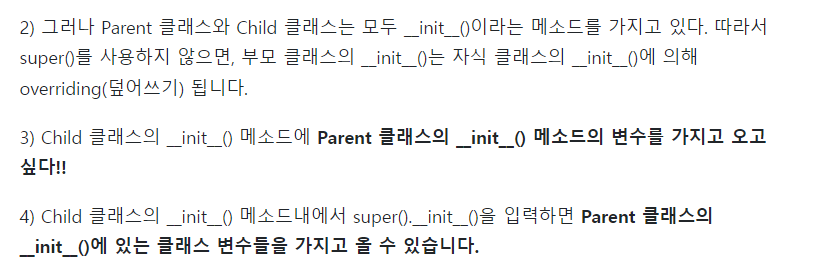

In [ ]:
import tensorflow as tf

class MyModel(tf.keras.Model):  # 모델 클래스를 상속받아 사용⭐⭐
  def __init__(self):
    # Model 클래스의 생성자를 직접 호출⭐
    # 복습 : super는 자식클래스가 부모클래스의 생성자를 책임져주는것
    super(MyModel, self).__init__()

    # Input 레이어가 따로 없다면, 첫 번째 레이어가 입력층의 역할을 대신 수행하게 할 수 있다.
    # input_shape 파라미터를 활용

    # init에선 사용할 파라미터들을 정의만 해놓는거
    self.flatten = Flatten(input_shape=(28,28))
    self.d1 = Dense(512, activation='relu')
    self.d2 = Dense(256, activation='relu')
    self.d3 = Dense(128, activation='relu')
    self.d4 = Dense(64, activation='relu')

    self.output = Dense(10, activation='softmax')


  # 생성자에서 정의한 레이어 엮기
  # call은 메소드의 이름이나 파라미터를 바꾸지 않아야한다. 오버라이딩 되는 메소드이기때문에
  # 결과물 반드시 리턴해야⭐
  def call(self, x):
    # 순전파수행
    x = self.flatten(x)

    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    x = self.d4(x)

    y = self.output(x)
    return y

    


# 학습 커스터마이징

    model : 학습대상 모델
    X : 학습에 사용할 feature 텐서
    y : 이미지에 맞는 레이블 텐서
    loss_func : 사용할  손실함수
    optimizer : 사용할 최적화 함수
    train_loss : 훈련 과정 loss 평가 지표 설정
    train_accuracy : 훈련 과정 acurracy 평가 지표 설정

In [ ]:
# decolator
# 텐서플로우 세션 내에서 작동하는 함수를 만들 때 사용
@tf.function
def train_step(model, X, y, loss_func, optimizer, train_loss, train_accuracy):
  # 모델의 학습 루틴넣어주기
  # 순전파 > 역전파 > 최적화

  # 자동미분 환경 구성(순전파때 썼던 함수들 자동미분계획세워주기)
  with tf.GradientTape() as tape:

    # 순전파💛
    prediction = model(X) # 자동미분 환경내에서 예측모드로 바뀐다.
    loss = loss_func(y, prediction)

  # 역전파🧡(미분배열구하기)
  grads = tape.gradient(loss, model.trainable_variables)
  # model.trainable_variables : 훈련가능한 변수 즉 W,b

  # 최적화
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  # 훈련결과 기록해놓기
  train_loss(loss)
  train_accuracy(y, prediction)

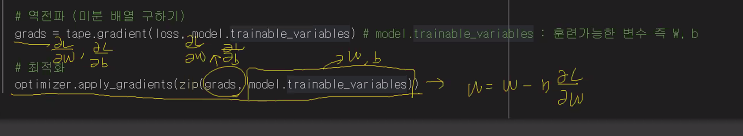